### Import Libraries

In [1]:
import torch
import math
import random
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import transforms
import numpy as np
import os
import glob
import cv2
from PIL import Image
from torch import optim, nn
from torch.nn.utils import clip_grad_norm_

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

### Data Preparation

In [2]:
%%bash
rm -rf images

In [3]:
%%bash
ls -v images/Dataset/Flicker8k_Dataset/ | cat -n

ls: cannot access 'images/Dataset/Flicker8k_Dataset/': No such file or directory


In [4]:
%%bash
mkdir images
wget -O images/Dataset.zip https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip 
mkdir images/original
unzip -d images/Dataset/ images/Dataset.zip
ls -v images/Dataset/Flicker8k_Dataset/ | cat -n | while read n f; do mv -n "images/Dataset/Flicker8k_Dataset/$f" "images/original/$n.jpg"; done
wget -O images/watermark.png https://drive.google.com/uc?id=19g2xehk2ygH4WWZu6G7ir883NNtVyjjo&export=download
mkdir images/watermarked
mkdir images/not_watermarked
rm -rf images/Dataset
rm -rf images/Dataset.zip

Output hidden; open in https://colab.research.google.com to view.

In [5]:
%%bash
ls -l images/original/ | grep -v ^d | wc -l

8092


In [6]:
def gen_watermark(og_img_path, watermark_img_path, output_path, not_marked_path, w, h):
  # Randomly select transparency
  TRANSPARENCY = random.randint(10, 100)

  # Read the original image + dimension
  og_img = glob.glob(og_img_path)

  print('Adding watermarks')
  samples = 0

  # Original image resizing dims
  resize_w = w
  resize_h = h

  for i in og_img:
      img = Image.open(i)
      img = img.resize((resize_w, resize_h))
      img_w, img_h = img.size

      samples += 1

      filename = os.path.basename(i)
      # Save resized original image
      img.save(not_marked_path + filename)

      # Read the watermark image + dimension
      watermark = Image.open(watermark_img_path)

      # Resize the watermark in proportion to original image
      basewidth = img_w // 2
      wpercent = (basewidth / float(watermark.size[0]))
      hsize = int((float(watermark.size[1]) * float(wpercent)))
      watermark = watermark.resize((basewidth, hsize), Image.ANTIALIAS)

      # If watermark image is not a PNG
      if watermark.mode!='RGBA':
          alpha = Image.new('L', watermark.size, 255)
          watermark.putalpha(alpha)

      watermark_w, watermark_h = watermark.size

      ## Randomly assign watermark coordinates
      #water_w, water_h = (random.randint(0, img_w - watermark_w), random.randint(0, img_h - watermark_h))
      #Assign watermark coordinates
      water_w, water_h = (int((img_w - watermark_w)/2), int((img_h - watermark_h)/2))
      

      paste_mask = watermark.split()[3].point(lambda i: i * TRANSPARENCY / 100.)
      img.paste(watermark, (water_w, water_h), mask=paste_mask)
      
      filename = os.path.basename(i)
      # Save watermarked image
      img.save(output_path + filename)

  print('Watermark added to all the images')
  return samples

In [7]:
class watermarkDataset:
  def __init__(self, original_path, watermarked_path, len, transform=None, output_transform=None):
        self.original_path = original_path
        self.watermarked_path = watermarked_path
        self.length = len
        self.transform = transform
        self.output_transform = output_transform

  def __len__(self):
    return self.length

  def __getitem__(self, idx):
    # print(idx)
    if torch.is_tensor(idx):
        idx = idx.tolist()
    idx +=1
    original_img_name = os.path.join(self.original_path,
                            str(idx) + '.jpg')
    watermarked_img_name = os.path.join(self.watermarked_path,
                            str(idx) + '.jpg')

    original_image = Image.open(original_img_name)
    watermarked_image = Image.open(watermarked_img_name)
    if original_image is None or watermarked_image is None:
      print(original_img_name)
      print(watermarked_img_name)

    if self.transform:
      original_image = self.transform(original_image)
    if self.output_transform:
      watermarked_image = self.output_transform(watermarked_image)

    return original_image, watermarked_image

In [8]:
width=400
height=400
colors=3
og_img_path = 'images/original/*.*'
watermark_img_path = 'images/watermark.png'
output_path = 'images/watermarked/'
not_marked_path = 'images/not_watermarked/'
samples = gen_watermark(og_img_path, watermark_img_path, output_path, not_marked_path, width, height)

Adding watermarks
Watermark added to all the images


In [9]:
tform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

data = watermarkDataset('images/not_watermarked/',
                        'images/watermarked/',
                        len=samples,
                        transform=tform,
                        output_transform=tform)
                        # transform = torchvision.transforms.ToTensor,
                        # output_transform = torchvision.transforms.ToTensor)

In [10]:
def get_data_loader(data, batch_size):
  train_data, validation_data = torch.utils.data.random_split(data, [7000, samples - 7000])
  loader_kwargs = {
    'batch_size': batch_size,
    'shuffle': True,
    'num_workers': 4,
    'pin_memory': True,
    'drop_last': True,
  }
  train_loader = DataLoader(train_data, **loader_kwargs)
  val_loader = DataLoader(validation_data, **loader_kwargs)
  return train_loader, val_loader

In [11]:
batch_size=40
train_loader, val_loader = get_data_loader(data, batch_size)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
torch.Size([40, 3, 400, 400])


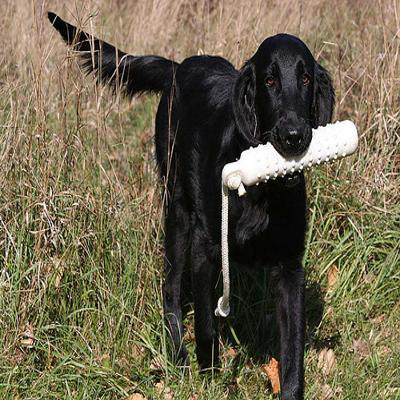

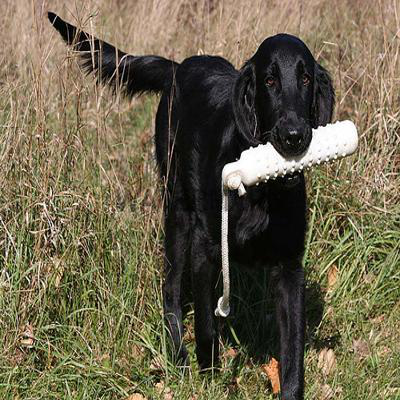

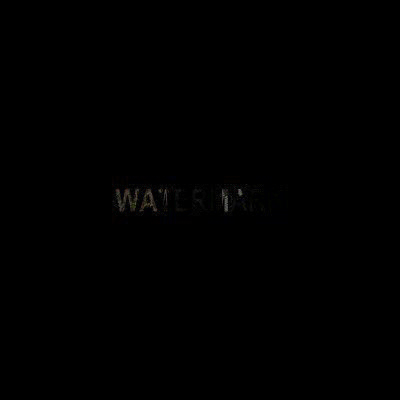

In [12]:
show=True
for batch, data in enumerate(train_loader):
  original, watermarked = data
  if show:
    print(batch)
    print(original.shape)
    im_o = transforms.ToPILImage()(original[0])
    im_w = transforms.ToPILImage()(watermarked[0])
    im_diff = transforms.ToPILImage()(abs(original[0] - watermarked[0]))

    display(im_o)
    display(im_w)
    display(im_diff)
    show=False
  else:
    break


##Make a pixel distribution
#Image.open()

### Model

In [13]:
from scipy import ndimage
'''
image_data shape is (color, w, h)
'''
def gradient(image_data):
  grad = np.zeros_like(image_data)
  count=0
  for color_channel in image_data:
    cc_grad_x = ndimage.sobel(color_channel,axis=0,mode='constant')
    cc_grad_y = ndimage.sobel(color_channel,axis=1,mode='constant')
    grad[count] = np.sqrt((cc_grad_x * cc_grad_x) + (cc_grad_y * cc_grad_y))
    count+=1
  return grad

imgs = []
count=0
for batch, data in enumerate(train_loader):
  original, watermarked = data
  imgs.append(watermarked[0])
  if(count==100):
    break
  count+=1
  #for image in watermarked:
  #  imgs.append(image)
grads = []
print("imgs",len(imgs))
for image in imgs:
    grads.append(gradient(image.numpy()))
len_grads = len(grads)

#find median gradient
np_grads = np.zeros((len_grads,colors,width,height))
for i in np.arange(len_grads):
  np_grads[i] = grads[i]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


imgs 101


torch.Size([3, 400, 400])


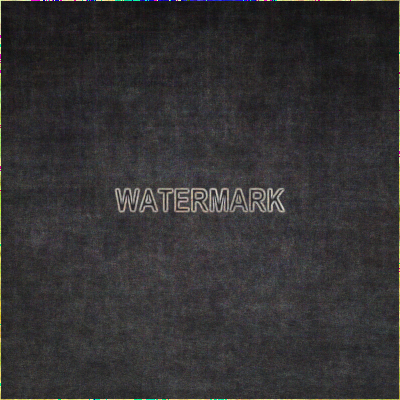

In [14]:

median_gradient = torch.from_numpy(np.median(grads, axis=0))
print(median_gradient.shape)
im_median_gradient = transforms.ToPILImage()(median_gradient)
display(im_median_gradient)

In [15]:
show=True
for batch, data in enumerate(train_loader):
  original, watermarked = data
  if show:
    print(batch)
    print(original.shape)
    im_o = transforms.ToPILImage()(original[0])
    im_w = transforms.ToPILImage()(watermarked[0])
    im_diff = transforms.ToPILImage()(abs(original[0] - watermarked[0]))
    im_pred = transforms.ToPILImage()(watermarked[0] + median_gradient)

    display(im_o)
    display(im_w)
    display(im_diff)
    display(im_pred)
    show=False
  else:
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored